In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim
import torch.nn.functional as F

from torchsummary import summary

import sys
sys.path.append("../../")
from utils import metrics

Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 413 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


In [2]:
def seq_tar_gen(raw_data, tw=16, pw=1):
    """
    des:
        输入时间序列，构造用于监督学习的样本（[seq， tar]形式）
    para: 
        raw_data:
        tw:
        pw:
    return:
    """
    sample = []
    for i in range(len(raw_data) - tw):
        sample.append([raw_data[i:i + tw], raw_data[i + tw: i + tw + pw]])
    return sample

# sequence-target-generator测试
raw_data = np.array(range(10))
test_seq = seq_tar_gen(raw_data=raw_data, tw=6, pw=1)
for seq in test_seq:
    print(seq)

[array([0, 1, 2, 3, 4, 5]), array([6])]
[array([1, 2, 3, 4, 5, 6]), array([7])]
[array([2, 3, 4, 5, 6, 7]), array([8])]
[array([3, 4, 5, 6, 7, 8]), array([9])]


In [3]:
# 多层感知机
class MLPNet(nn.Module):
    def __init__(self, n_features=16, n_outputs=1, hidden_layers=[16, 8, 4, 2]):
        super(MLPNet, self).__init__()
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden_layers = hidden_layers
        self.n_mlp_layers = len(hidden_layers)

        self.input2mlp = nn.Linear(self.n_features, self.hidden_layers[0])
        mlp = []
        for i in range(self.n_mlp_layers):
            if i == self.n_mlp_layers - 1:
                # mlp.append(nn.LeakyReLU())
                mlp.append(nn.Linear(self.hidden_layers[-1], n_outputs))
            else:
                # mlp.append(nn.LeakyReLU())
                mlp.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i + 1]))
        self.mlp = nn.Sequential(*mlp)

    def forward(self, x):
        input_size = x.size(0) # input_size 即 batch_size
        x = self.input2mlp(x)
        x = self.mlp(x)
        return x
    
# model = MLPNet()
# print(model)

## CALCE数据集

In [4]:
# Dataset
class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        sample = self.data[index]
        seq = torch.FloatTensor(sample[0])
        tar = torch.FloatTensor(sample[1])
        return seq, tar

In [5]:
# 读取容量数据
battery_names = []
calce_data_path = "../../data/processed_data/calce/calce_capacity.npy"
calce_data = np.load(calce_data_path, allow_pickle=True)

b35 = calce_data[0]
b36 = calce_data[1]
b37 = calce_data[2]
b38 = calce_data[3]


window_size = 16
b35 = seq_tar_gen(b35, window_size)
b36 = seq_tar_gen(b36, window_size)
b37 = seq_tar_gen(b37, window_size)
b38 = seq_tar_gen(b38, window_size)

# b35 = CALCEBattery(b35)
# print(b35[0][0].shape, b35[0][1].shape) # torch.Size([16]) torch.Size([1])

In [6]:
USE_CUDA = torch.cuda.is_available()
device = "cuda" if USE_CUDA else "cpu"
print(f"using device: {device}")

epochs = 20
lr = 1e-2
window_size = 16
batch_size = 16

using device: cuda


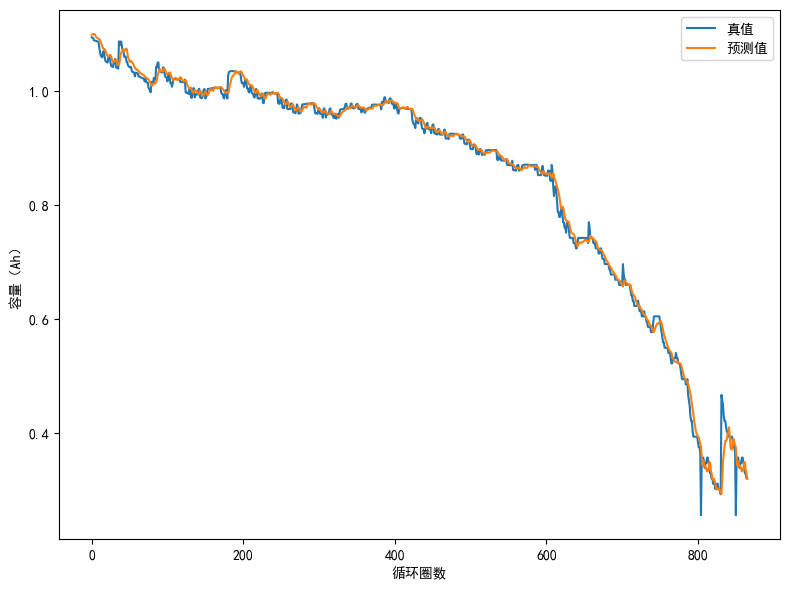

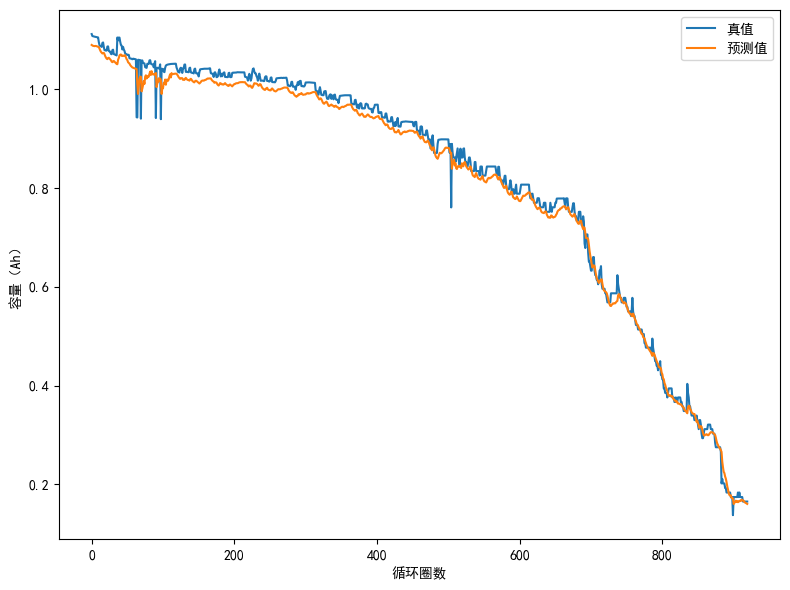

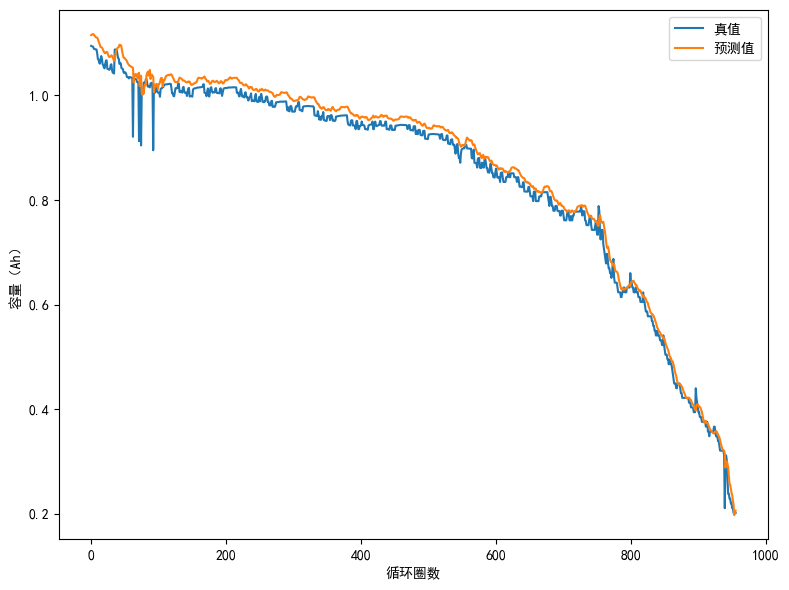

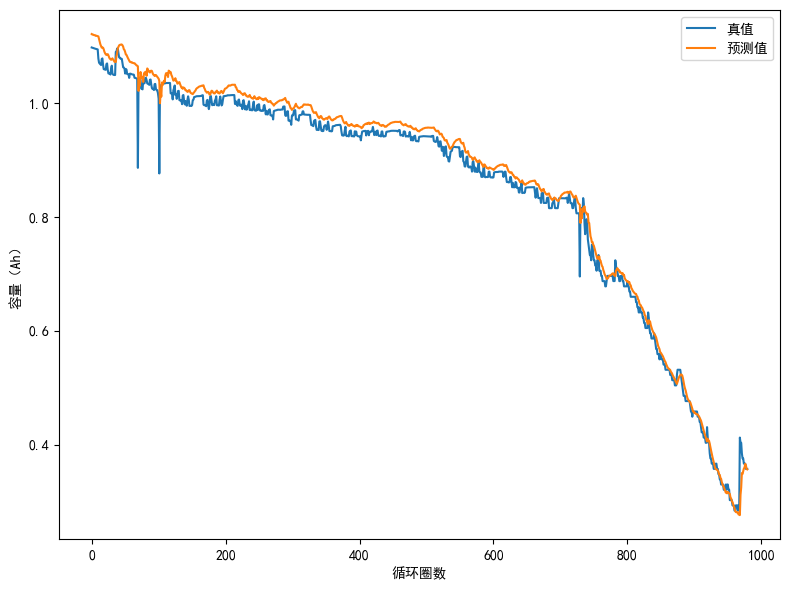

In [7]:
dataset = (b35, b36, b37, b38)
battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

# fig, ax = plt.subplots(1, 4, figsize=(15, 3))

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i], dtype=object)
    test_dataset = dataset[idx]

    train_dataset = BatteryDataset(train_dataset)
    test_dataset = BatteryDataset(test_dataset)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model = MLPNet(hidden_layers=[16]).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    train_loss, val_loss = 0.0, 0.0
    for epoch in range(epochs):
        model.train()
        
        # 训练
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = train_loss / len(train_dataloader)
        train_losses.append(epoch_loss)

        # 验证
        # model.eval()
        # for X, y in test_dataloader:
        #     with torch.no_grad():
        #         X, y = X.to(device), y.squeeze().to(device)
        #         preds = model(X).squeeze()
        #         error = criterion(preds, y)
        #     val_loss += error
        # val_loss = val_loss / len(test_dataloader)
        # val_losses.append(val_loss)

        # 打印训练和验证信息
        # print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

    # 可视化验证集上结果hidden_sate
    y_pred, gt, y1, y2 = [], [], [], []
    cycle = [i + 1 for i in range(len(test_dataset))]
    for X, y in test_dataset:
        y = y.item()
        gt.append(y)
        y1.append(y * (1 + 0.05))
        y2.append(y * (1 - 0.05))
    model.eval()
    for cnt, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.squeeze().to(device)
        y_pred += model(X).cpu().squeeze().tolist()
        

    # ax[idx].plot(gt)
    # plt.fill_between(cycle, y1, y2, alpha=0.5)
    # ax[idx].plot(y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(gt)
    plt.plot(y_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数")
    plt.ylabel("容量（Ah）")
    save_path = f"../../assets/thesis_figures/chapter_3/calce_{battery_names[idx]}_mlp.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

## NASA数据集

In [8]:
# 读取容量数据
nasa_data_path = "../../data/processed_data/nasa/nasa_capacity.npy"
nasa_data = np.load(nasa_data_path, allow_pickle=True)

b05 = nasa_data[0]
b06 = nasa_data[1]
b07 = nasa_data[2]
b18 = nasa_data[3]

window_size = 16
b05 = seq_tar_gen(b05, window_size)
b06 = seq_tar_gen(b06, window_size)
b07 = seq_tar_gen(b07, window_size)
b18 = seq_tar_gen(b18, window_size)

using device: cuda


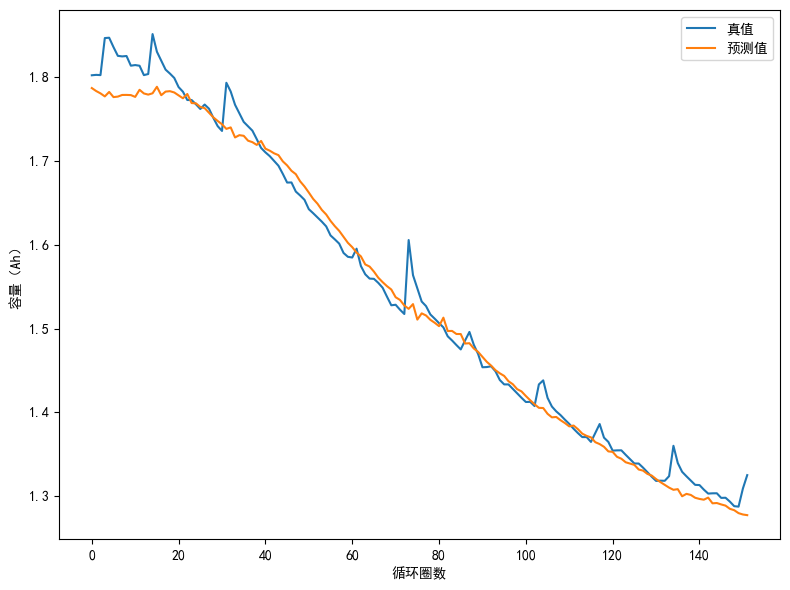

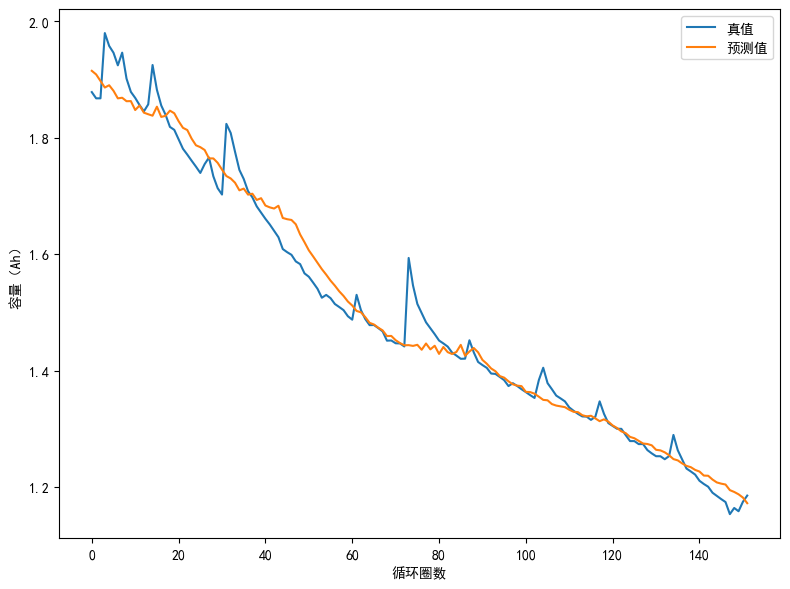

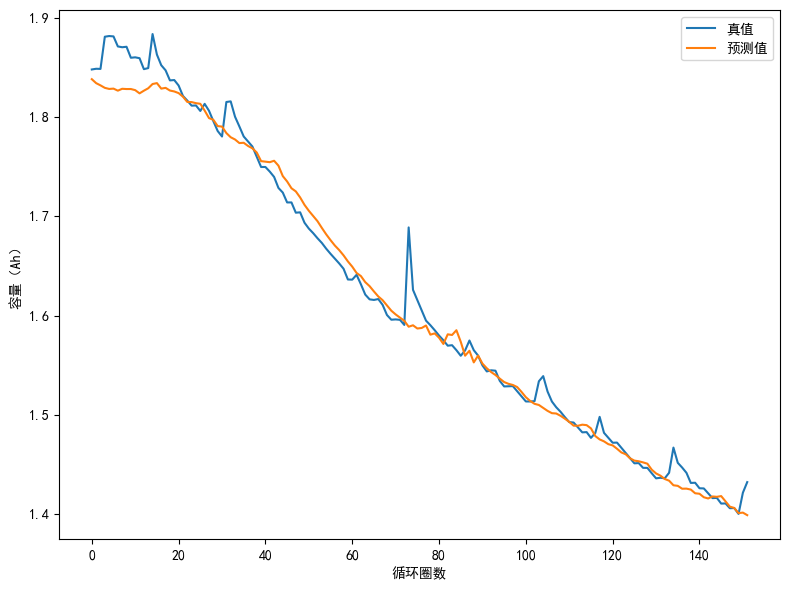

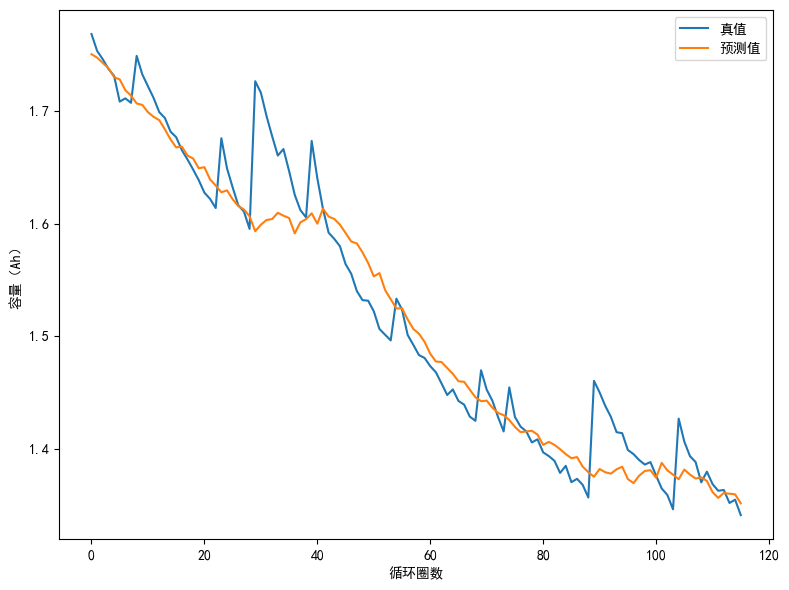

In [10]:
USE_CUDA = torch.cuda.is_available()
device = "cuda" if USE_CUDA else "cpu"
print(f"using device: {device}")

epochs = 20
lr = 1e-2
window_size = 16
batch_size = 16

dataset = (b05, b06, b07, b18)
battery_names = ["B0005", "B0006", "B0007", "B0018"]

# fig, ax = plt.subplots(1, 4, figsize=(15, 3))

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i], dtype=object)
    test_dataset = dataset[idx]

    train_dataset = BatteryDataset(train_dataset)
    test_dataset = BatteryDataset(test_dataset)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model = MLPNet(hidden_layers=[16]).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    train_loss, val_loss = 0.0, 0.0
    for epoch in range(epochs):
        model.train()
        
        # 训练
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = train_loss / len(train_dataloader)
        train_losses.append(epoch_loss)

        # 验证
        # model.eval()
        # for X, y in test_dataloader:
        #     with torch.no_grad():
        #         X, y = X.to(device), y.squeeze().to(device)
        #         preds = model(X).squeeze()
        #         error = criterion(preds, y)
        #     val_loss += error
        # val_loss = val_loss / len(test_dataloader)
        # val_losses.append(val_loss)

        # 打印训练和验证信息
        # print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

    # 可视化验证集上结果hidden_sate
    y_pred, gt, y1, y2 = [], [], [], []
    cycle = [i + 1 for i in range(len(test_dataset))]
    for X, y in test_dataset:
        y = y.item()
        gt.append(y)
        y1.append(y * (1 + 0.05))
        y2.append(y * (1 - 0.05))
    model.eval()
    for cnt, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.squeeze().to(device)
        y_pred += model(X).cpu().squeeze().tolist()
        

    # ax[idx].plot(gt)
    # # plt.fill_between(cycle, y1, y2, alpha=0.5)
    # ax[idx].plot(y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(gt)
    plt.plot(y_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数")
    plt.ylabel("容量（Ah）")
    save_path = f"../../assets/thesis_figures/chapter_3/nasa_{battery_names[idx]}_mlp.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()